In [1]:
import sys
import numpy as np
sys.path.append('../')

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import requests
from io import BytesIO
from PIL import Image
import numpy as np
from PIL import Image

%load_ext autoreload
%autoreload 2



# End to end on avenue image

House number:  [1877]


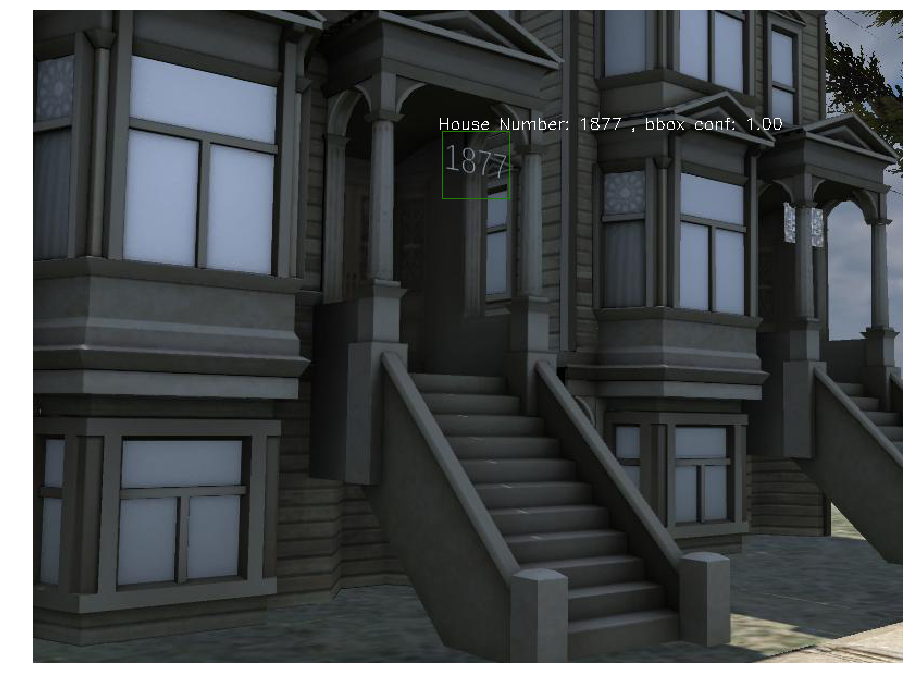

In [2]:
from humanware.end_to_end import AvenueDetector
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import sys

sys.path.append('../')

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 30, 16

from maskrcnn_benchmark.config import cfg

def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

config_file = "../configs/avenue_e2e_faster_rcnn_R_101_FPN_1x.yaml"

# update the config options with the config file
cfg.merge_from_file(config_file)
# manual override some options
cfg.merge_from_list(["MODEL.DEVICE", "cpu"])

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20, 12

avenue_detector = AvenueDetector(
    cfg,
    min_image_size=800,
    confidence_threshold=0.7,
)

# good examples on 4043, 4049
pil_image = Image.open('/home/jerpint/digit-detection/data/Avenue/Humanware_v1_1551895483/test/image_4043.jpg').convert("RGB")

# convert to BGR format, as this is what our model expects
image = np.array(pil_image)[:, :, [2, 1, 0]]
prediction_img, predictions, house_number = avenue_detector.run_on_opencv_image(image)
imshow(prediction_img)

print("House number: ", house_number)



# Detection on single digit (SVHN)

House number:  [418]


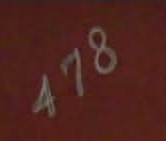

In [3]:
svhn_sample_img = Image.open("/home/jerpint/digit-detection/data/SVHN/extra/1.png")
house_number = avenue_detector.extract_house_number(svhn_sample_img)
print("House number: ", house_number)
svhn_sample_img
